In [169]:
!pip install -U imblearn

In [170]:
import os
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.over_sampling import SMOTENC, SVMSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
# torch api
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchsummary import summary
from sklearn.impute import SimpleImputer
# device add gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")       # 使用Nvidia 顯卡
device

device(type='cpu')

## 讀取資料集

In [171]:
# 讀取數據
data_train = pd.read_csv('./data/train.csv', index_col=False)

In [172]:
data_train

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,61676,Male,77.0,0,0,Yes,Self-employed,Urban,68.38,25.1,Unknown,0
1,56923,Male,52.0,1,0,Yes,Private,Rural,116.21,32.8,smokes,0
2,48265,Male,65.0,0,0,Yes,Govt_job,Rural,111.85,26.7,never smoked,0
3,11843,Female,65.0,0,0,Yes,Self-employed,Rural,80.42,29.4,formerly smoked,0
4,57917,Female,47.0,0,0,Yes,Private,Urban,157.01,26.1,smokes,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4083,8719,Male,12.0,0,0,No,children,Urban,116.25,16.4,formerly smoked,0
4084,56282,Male,13.0,0,0,No,Private,Rural,90.60,16.9,never smoked,0
4085,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
4086,66196,Male,75.0,0,1,No,Private,Rural,201.76,30.2,formerly smoked,0


In [173]:
data_test = pd.read_csv("./data/test.csv", index_col=False)

In [174]:
data_train.info()
# data_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4088 entries, 0 to 4087
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4088 non-null   int64  
 1   gender             4088 non-null   object 
 2   age                4088 non-null   float64
 3   hypertension       4088 non-null   int64  
 4   heart_disease      4088 non-null   int64  
 5   ever_married       4088 non-null   object 
 6   work_type          4088 non-null   object 
 7   Residence_type     4088 non-null   object 
 8   avg_glucose_level  4088 non-null   float64
 9   bmi                3928 non-null   float64
 10  smoking_status     4088 non-null   object 
 11  stroke             4088 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 383.4+ KB


In [175]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1022 non-null   int64  
 1   gender             1022 non-null   object 
 2   age                1022 non-null   float64
 3   hypertension       1022 non-null   int64  
 4   heart_disease      1022 non-null   int64  
 5   ever_married       1022 non-null   object 
 6   work_type          1022 non-null   object 
 7   Residence_type     1022 non-null   object 
 8   avg_glucose_level  1022 non-null   float64
 9   bmi                981 non-null    float64
 10  smoking_status     1022 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 88.0+ KB


缺失值檢測
重點關注 Non-Null Count：

- 如果某欄位的 Non-Null Count < 總筆數，表示有缺失值
- 例如：bmi: 981 non-null，表示 bmi 欄位有 1022 - 981 = 41 個缺失值

## 資料清理與前處理

In [176]:
# 數據預處理
def preprocess_data(data):
    # 複製數據
    df = data.copy()
    
    # 處理缺失值 - BMI
    if df['bmi'].isnull().sum() > 0:
        imputer = SimpleImputer(strategy='median')
        df['bmi'] = imputer.fit_transform(df[['bmi']])
    
    # 根據風險因子創建特徵工程
    # 1. 年齡分組 (0-18, 18-35, 36-50, 51-65, >65)
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 18, 35, 50, 65, 100], 
                            labels=['<18', '18-35', '36-50', '51-65', '>65'])
    
    # 2. 高風險年齡標記(65歲以上)
    df['high_risk_age'] = (df['age'] >= 65).astype(int)
    
    # 3. BMI分組(根據WHO標準)
    # BMI 分組: <18.5 (underweight), 18.5-24.9 (normal), 25-29.9 (overweight), >=30 (obese)
    df['bmi_group'] = pd.cut(df['bmi'], 
                            bins=[0, 18.5, 25, 30, 100], 
                            labels=['underweight', 'normal', 'overweight', 'obese'])
    
    # 4. 血糖分組(根據WHO標準)
    # 血糖分組: <100 (normal), 100-125 (prediabetes), 126-200 (diabetes), >200 (high)
    df['glucose_group'] = pd.cut(df['avg_glucose_level'], 
                                bins=[0, 100, 126, 200, 400], 
                                labels=['normal', 'prediabetes', 'diabetes', 'high'])
    
    # 5. 多重風險因子組合(高血壓 + 心臟病 + 高風險年齡)
    df['multiple_risks'] = (df['hypertension'] + df['heart_disease'] + df['high_risk_age']).astype(int)
    
    # 6. 慢性病組合(高血壓 + 心臟病)
    df['chronic_diseases'] = (df['hypertension'] + df['heart_disease']).astype(int)
    

    return df

# 編碼類別特徵
def encode_categorical_features(train_df, test_df):
    
    # 需要編碼的類別特徵
    categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 
                           'smoking_status', 'age_group', 'bmi_group', 'glucose_group']
    
    # 使用 get_dummies 進行 one-hot encoding
    train_encoded = pd.get_dummies(train_df, columns=categorical_features, prefix=categorical_features)
    test_encoded = pd.get_dummies(test_df, columns=categorical_features, prefix=categorical_features)
    
    # 獲取所有特徵(確保訓練和測試數據有相同的特徵)
    all_features = set(train_encoded.columns) | set(test_encoded.columns)
    
    # 為缺失的特徵添加零列
    for feature in all_features:
        if feature not in train_encoded.columns:
            train_encoded[feature] = 0
        if feature not in test_encoded.columns:
            test_encoded[feature] = 0
    
    # 確保列順序相同
    feature_order = sorted([col for col in train_encoded.columns if col not in ['id', 'stroke']])
    
    return train_encoded, test_encoded, feature_order

# 預處理訓練和測試數據
train_processed = preprocess_data(data_train)
test_processed = preprocess_data(data_test)

# 編碼類別變數
train_encoded, test_encoded, feature_order = encode_categorical_features(train_processed, test_processed)

# 準備訓練數據
X_features = train_encoded[feature_order]  # 特徵資料
y_stroke = train_encoded['stroke']         # 中風目標

# 準備測試數據
X_test = test_encoded[feature_order]

## 切分資料集 (train, val, test)

In [177]:
# 使用訓練資料 - 分割訓練和驗證集
X_train, X_val, y_train, y_val = train_test_split(
    X_features, y_stroke, 
    test_size=0.2, 
    random_state=2610, 
    stratify=y_stroke
)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(3270, 37) (818, 37) (3270,) (818,)


各變數意義：
- X_train：訓練集的特徵資料
- X_val：驗證集的特徵資料
- y_train：訓練集的標籤資料
- y_val：驗證集的標籤資料

## 建立模型

In [178]:
## 建立訓練的 generator ，簡單來說因為資料量可能會偏大，所以使用generator可以將所有資料分成n筆資料訓練一次。
class Custom_Generator(Dataset):
    def __init__(self, X_data, y_data):
        # 確保資料是 numpy array 格式
        if hasattr(X_data, 'values'):
            self.X_data = X_data.values.astype(np.float32)
        else:
            self.X_data = np.array(X_data, dtype=np.float32)
            
        if hasattr(y_data, 'values'):
            self.y_data = y_data.values.astype(np.int64)
        else:
            self.y_data = np.array(y_data, dtype=np.int64)

    def __getitem__(self, index):
        data = self.X_data[index] # 取得第 index 筆特徵資料
        target = self.y_data[index]  # 取得第 index 筆標籤資料
        
        # 轉換為 tensor
        data = torch.FloatTensor(data) # 特徵轉為浮點數 tensor
        target = torch.LongTensor([target]).squeeze() # 標籤轉為長整數 tensor

        return data, target

    def __len__(self):
        return len(self.X_data)     # 回傳資料集數量

特徵資料用 FloatTensor：
- 適合數值計算和梯度更新
- 與模型權重的資料型態一致

標籤資料用 LongTensor：
- CrossEntropyLoss 需要整數類別標籤
- 分類問題的標準格式

In [179]:
# 由於我們的輸入資料的維度一定是(batch, input)，所以要將維度改成二維資料
# 確保 X_train 是 numpy array
if hasattr(X_train, 'values'):
    input_x = X_train.values.astype(np.float32)
else:
    input_x = np.array(X_train, dtype=np.float32)

# 確保 y_train 是 numpy array
if hasattr(y_train, 'values'):
    target_y = y_train.values.astype(np.int64)
else:
    target_y = np.array(y_train, dtype=np.int64)

# 1. 先呼叫我們寫好的Custom_Generator
train_data = Custom_Generator(X_data = input_x, y_data = target_y)

# 2. 呼叫pytorch的DataLoader來做批次動作，模型的輸入
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)  # 建議增加 batch_size

In [180]:
## 請建立屬於自己的模型
class DNN(nn.Module):
    def __init__(self, input_shape):
        super(DNN, self).__init__()
        
        # 定義網路層
        self.fc1 = nn.Linear(input_shape, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)  # 二元分類: 0(無中風), 1(中風)
        
        # Dropout層防止過度配適
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # 第一層
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # 第二層
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # 第三層
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # 輸出層
        x = self.fc4(x)
        
        return x

In [181]:
model = DNN(input_shape=X_train.shape[1]).to(device)
print(model)
summary(model, input_size=(X_train.shape[1],))

DNN(
  (fc1): Linear(in_features=37, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           4,864
           Dropout-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
           Dropout-4                   [-1, 64]               0
            Linear-5                   [-1, 32]           2,080
           Dropout-6                   [-1, 32]               0
            Linear-7                    [-1, 2]              66
Total params: 15,266
Trainable params: 15,266
Non-trainable params: 0
--------------------------------------------------------------

In [182]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 計算平衡的類別權重
class_weights = compute_class_weight(
    class_weight='balanced',           # 自動平衡權重
    classes=np.unique(y_train),       # 所有類別 [0, 1]
    y=y_train                         # 訓練標籤
)

# 將 class_weights 轉換為 tensor
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

## 請設定模型需要的 loss、learning rate、epoch、optimizer

In [183]:
# 設定loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
# learning rate
learning_rate = 0.001
# epochs數量
epochs = 300
# 優化器
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 存下模型

In [184]:
folder = 'save_model'
if not os.path.exists(folder):
    os.mkdir(folder)

model_path = './save_model/checkpoints_model.pth'  # 模型儲存的位置

In [185]:
## 可以決定要不要設定 schedule
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

In [186]:
def Train_Process(model, epochs, optimizer, criterion, l1_rate, trainloader, testloader, model_path):
    Train_loss = []
    Train_acc = []
    valid_loss = []
    valid_acc = []
    lr_rate = []
    Best_acc = 0

    # 第1步驟
    for epoch in range(epochs):
        # 訓練階段
        model.train()  # 設定為訓練模式
        running_loss = 0.0
        accuracy = 0
        total = 0

        # 第2步驟
        for times, data_train in enumerate(trainloader, 0):  # data_train會包括訓練的資料以及訓練的標籤
            # batch data input
            inputs, labels = data_train
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)

            # 第3步驟
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # model Feedforward
            outputs = model(inputs)

            # 第4步驟
            # Feed forward loss result
            loss = criterion(outputs, labels)

            # 第5步驟
            # backward update
            loss.backward()

            # 第6步驟
            # optimize
            optimizer.step()

            # 將每一筆資料的loss都加起來，假設有100筆資料就會有100個loss的結果
            # Compute loss
            running_loss += loss.item()

            # Compute Accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

            # 當一個epoch結束後，顯示結果
            if times+1 == len(trainloader):
                print('[%d/%d, %d/%d] loss: %.3f, acc: %.3f,' % (epoch+1,
                                                                 epochs,
                                                                 times+1,
                                                                 len(trainloader),
                                                                 running_loss/len(trainloader),
                                                                 accuracy / total),end = " ")
                Train_loss.append(running_loss/len(trainloader))
                Train_acc.append(accuracy / total)

        # 測試階段
        model.eval()  # 設定為評估模式
        valid_running_loss = 0.0
        valid_accuracy = 0
        valid_total = 0

        with torch.no_grad(): # disable gradient calculation for efficiency
            for times, data_test in enumerate(testloader, 0):
                # batch data input
                inputs, labels = data_test
                inputs = inputs.float().to(device)
                labels = labels.long().to(device)

                # model predict
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                valid_running_loss += loss.item()

                # Compute accuracy
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_accuracy += (predicted == labels).sum().item()

                if times+1 == len(testloader):
                    # 加入learning rate function
                    current_lr = optimizer.param_groups[0]['lr']
                    lr_rate.append(current_lr)
                    
                    valid_loss.append(valid_running_loss/len(testloader))
                    valid_acc.append(valid_accuracy / valid_total)
                    
                    print('valid_loss: %.3f, valid_acc: %.3f, lr: %.6f' % (
                        valid_running_loss/len(testloader),
                        valid_accuracy / valid_total,
                        current_lr
                    ))
                    
                    # 保存最佳模型
                    if valid_accuracy / valid_total > Best_acc:
                        Best_acc = valid_accuracy / valid_total
                        torch.save(model.state_dict(), model_path)
                        print(f'*** Best model saved with accuracy: {Best_acc:.3f} ***')
                    
                    # 更新學習率
                    if 'scheduler' in globals():
                        scheduler.step()

    return Train_loss, Train_acc, valid_loss, valid_acc, lr_rate

In [187]:
# 建立驗證資料的 DataLoader
input_x_val = np.reshape(X_val, (-1, X_val.shape[1]))
val_data = Custom_Generator(X_data = input_x_val, y_data = y_val)
testloader = DataLoader(val_data, batch_size=1, shuffle=False)

Train_loss, Train_acc, valid_loss, valid_acc, lr_rate = Train_Process(model = model,
                                                             epochs = epochs,
                                                             optimizer = optimizer,
                                                             criterion = criterion,
                                                             l1_rate = 0,  # 不使用L1正則化
                                                             trainloader = trainloader,
                                                             testloader = testloader,
                                                             model_path = model_path)


[1/300, 103/103] loss: 0.780, acc: 0.578, valid_loss: 0.652, valid_acc: 0.515, lr: 0.001000
*** Best model saved with accuracy: 0.515 ***
[2/300, 103/103] loss: 0.684, acc: 0.611, valid_loss: 0.617, valid_acc: 0.517, lr: 0.001000
*** Best model saved with accuracy: 0.517 ***
[3/300, 103/103] loss: 0.610, acc: 0.639, valid_loss: 0.589, valid_acc: 0.571, lr: 0.001000
*** Best model saved with accuracy: 0.571 ***
[4/300, 103/103] loss: 0.572, acc: 0.655, valid_loss: 0.413, valid_acc: 0.759, lr: 0.001000
*** Best model saved with accuracy: 0.759 ***
[5/300, 103/103] loss: 0.549, acc: 0.646, valid_loss: 0.300, valid_acc: 0.857, lr: 0.001000
*** Best model saved with accuracy: 0.857 ***
[6/300, 103/103] loss: 0.566, acc: 0.657, valid_loss: 0.372, valid_acc: 0.842, lr: 0.001000
[7/300, 103/103] loss: 0.526, acc: 0.692, valid_loss: 0.410, valid_acc: 0.733, lr: 0.001000
[8/300, 103/103] loss: 0.522, acc: 0.674, valid_loss: 0.445, valid_acc: 0.694, lr: 0.001000
[9/300, 103/103] loss: 0.510, acc:

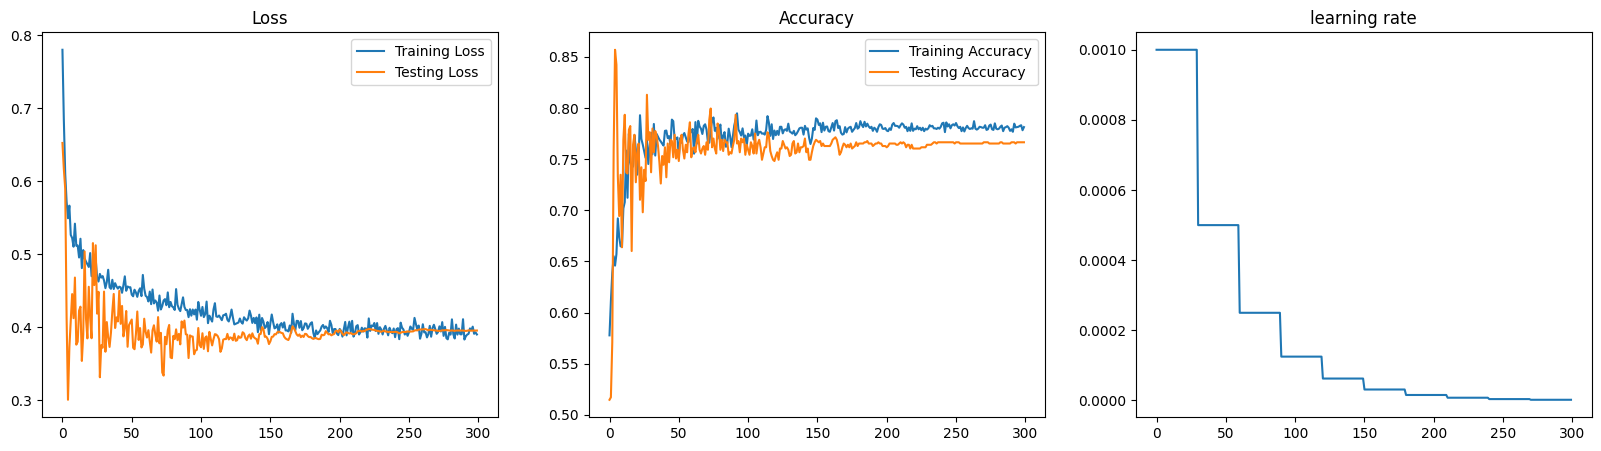

In [188]:
# 視覺化訓練過程
plt.figure(figsize=(20, 5))

# 繪製 Training loss 和 Validation loss
plt.subplot(131)
plt.plot(range(len(Train_loss)), Train_loss, label='Training Loss')
plt.plot(range(len(valid_loss)), valid_loss, label='Testing Loss')
plt.legend(loc='best')
plt.title('Loss')

# 繪製 Training accuracy 和 Validation accuracy
plt.subplot(132)
plt.plot(range(len(Train_acc)), Train_acc, label='Training Accuracy')
plt.plot(range(len(valid_acc)), valid_acc, label='Testing Accuracy')
plt.legend(loc='best')
plt.title('Accuracy')

# 繪製 Training accuracy 和 Validation accuracy
plt.subplot(133)
plt.plot(range(len(lr_rate)), lr_rate, label='learning rate')
plt.title('learning rate')

plt.show()

In [189]:
Model_X_test = torch.from_numpy(X_val.values.astype(np.float32)).to(device)
y_test_pred = model(Model_X_test)
y_test_pred = y_test_pred.cpu().data.numpy()
y_test_pred_id = np.argmax(y_test_pred, axis=-1)

In [190]:
report = classification_report(y_pred = y_test_pred_id, y_true = y_val)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.77      0.86       778
           1       0.13      0.68      0.22        40

    accuracy                           0.77       818
   macro avg       0.56      0.72      0.54       818
weighted avg       0.94      0.77      0.83       818



In [191]:
cnfm = confusion_matrix(y_pred = y_test_pred_id, y_true = y_val)
cnfm = pd.DataFrame(cnfm, columns=['Pred_0', 'Pred_1'], index=['Act_0', 'Act_1'])
cnfm

,Pred_0,Pred_1
Act_0,600,178
Act_1,13,27


In [192]:
# 載入最佳模型進行預測
model.load_state_dict(torch.load(model_path))
model.eval()

# 對測試資料進行預測
with torch.no_grad():
    Model_test = torch.from_numpy(X_test.values.astype(np.float32)).to(device)
    y_test_pred = model(Model_test)
    y_test_pred = y_test_pred.cpu().data.numpy()
    y_test_pred_id = np.argmax(y_test_pred, axis=-1)

# 讀取原始測試資料的 ID
test_ids = data_test['id'].values

# 建立預測結果的 DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'stroke': y_test_pred_id
})

# 輸出為 CSV 檔案
submission.to_csv('./submission.csv', index=False)
print("預測結果已儲存至 submission.csv")



預測結果已儲存至 submission.csv


## Inference

In [193]:
test = pd.read_csv('./data/test.csv', index_col=False)

In [194]:
# test資料前處理

In [195]:
# test資料前處理
# 使用之前已經預處理好的 X_test (這是經過特徵工程和編碼的測試資料)
Model_test = torch.from_numpy(X_test.values.astype(np.float32)).to(device)
y_test_pred = model(Model_test)
y_test_pred = y_test_pred.cpu().data.numpy()
y_test_pred_id = np.argmax(y_test_pred, axis=-1)

In [196]:
sol = pd.read_csv(f'./data/solution.csv', header=0)

FileNotFoundError: [Errno 2] No such file or directory: './data/solution.csv'

In [ ]:
report = classification_report(y_pred = y_test_pred_id, y_true = sol.Stroke)
print(report)

In [ ]:
cnfm = confusion_matrix(y_pred = y_test_pred_id, y_true = sol.Stroke)
cnfm = pd.DataFrame(cnfm, columns=['Pred_0', 'Pred_1'], index=['Act_0', 'Act_1'])
cnfm